# Neural Collaborative Filtering

The paper "Neural Collaborative Filtering" (https://arxiv.org/pdf/1708.05031.pdf) aims to improve traditional collaborative filtering by replacing the inner product with a neural architecture that can learn an arbitrary function from the data. To supercharge NCF modelling with non-linearities, the authors propose to leverage a multi-layer perceptron (MLP) to learn the user-item interaction function.

This notebook implements and explores the NCF-GMF and NCF-MLP frameworks.

## Imports

In [ ]:
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

## Data
The MovieLens dataset (ml-latest-small) describes 5-star rating and free-text tagging activity from MovieLens, a movie recommendation service. It contains 100004 ratings and 1296 tag applications across 9125 movies.

In [ ]:
data = pd.read_csv("ratings.csv")

## Encode Data

In [ ]:
# split train and validation before encoding
np.random.seed(3)
msk = np.random.rand(len(data)) < 0.8
train = data[msk].copy()
val = data[~msk].copy()

In [ ]:
# here is a handy function modified from fast.ai
def proc_col(col, train_col=None):
    """Encodes a pandas column with continuous ids.
    """
    if train_col is not None:
        uniq = train_col.unique()
    else:
        uniq = col.unique()
    name2idx = {o:i for i,o in enumerate(uniq)}
    return name2idx, np.array([name2idx.get(x, -1) for x in col]), len(uniq)

In [ ]:
def encode_data(df, train=None):
    """ Encodes rating data with continous user and movie ids.
    If train is provided, encodes df with the same encoding as train.
    """
    df = df.copy()
    for col_name in ["userId", "movieId"]:
        train_col = None
        if train is not None:
            train_col = train[col_name]
        _,col,_ = proc_col(df[col_name], train_col)
        df[col_name] = col
        df = df[df[col_name] >= 0]
    return df

In [ ]:
# encoding the train and validation data
df_train = encode_data(train)
df_val = encode_data(val, train)

In [ ]:
df_train.head(10)

,userId,movieId,rating,timestamp
0,0,0,4.0,964982703
1,0,1,4.0,964981247
2,0,2,4.0,964982224
3,0,3,5.0,964983815
6,0,4,5.0,964980868
7,0,5,4.0,964982176
8,0,6,5.0,964984041
9,0,7,5.0,964984100
10,0,8,5.0,964983650
11,0,9,5.0,964981208


## Evaluate model parameters for NCF-GMF

In [ ]:
# NCF-GMF implementation
class MF(nn.Module):
    def __init__(self, num_users, num_items, emb_size=100):
        super(MF, self).__init__()
        self.user_emb = nn.Embedding(num_users, emb_size)
        self.item_emb = nn.Embedding(num_items, emb_size)
        self.user_emb.weight.data.uniform_(0, 0.05)
        self.item_emb.weight.data.uniform_(0, 0.05)

    def forward(self, u, v):
        u = self.user_emb(u)
        v = self.item_emb(v)
        return (u*v).sum(1)

In [ ]:
num_users = len(df_train.userId.unique())
num_items = len(df_train.movieId.unique())
print(num_users, num_items)

610 8998


In [ ]:
# Training Loop
def train_epocs(model, epochs=10, lr=0.01, wd=0.0):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    model.train()
    for i in range(epochs):
        # Train
        users = torch.LongTensor(df_train.userId.values) # .cuda()
        items = torch.LongTensor(df_train.movieId.values) #.cuda()
        ratings = torch.FloatTensor(df_train.rating.values) #.cuda()

        y_hat = model(users, items)
        loss = F.mse_loss(y_hat, ratings)
        optimizer.zero_grad()

        loss.backward()
        optimizer.step()

        # Val
        users_val = torch.LongTensor(df_val.userId.values) # .cuda()
        items_val = torch.LongTensor(df_val.movieId.values) #.cuda()
        ratings_val = torch.FloatTensor(df_val.rating.values) #.cuda()

        y_hat_val = model(users_val, items_val)
        loss_val = F.mse_loss(y_hat_val, ratings_val)

        # Display loss
        print(f"Epoch {i}: Training loss: {loss.item():.4f}  Validation loss: {loss_val.item():.4f}")

    final_val_loss_value = test_loss(model)
    return final_val_loss_value

def test_loss(model):
    model.eval()
    users = torch.LongTensor(df_val.userId.values) #.cuda()
    items = torch.LongTensor(df_val.movieId.values) #.cuda()
    ratings = torch.FloatTensor(df_val.rating.values) #.cuda()
    y_hat = model(users, items)
    loss = F.mse_loss(y_hat, ratings)
    print("test loss %.3f " % loss.item())
    return loss.item()

### Experiments to determine impact of regularization and embedding size on the model performance

===== Train with Embedding Size of 50 ======
Epoch 0: Training loss: 13.1301  Validation loss: 8.5638
Epoch 1: Training loss: 8.4985  Validation loss: 2.6089
Epoch 2: Training loss: 2.5938  Validation loss: 2.2174
Epoch 3: Training loss: 2.2051  Validation loss: 4.3116
Epoch 4: Training loss: 4.1543  Validation loss: 2.0916
Epoch 5: Training loss: 1.8977  Validation loss: 1.0120
Epoch 6: Training loss: 0.8076  Validation loss: 1.7446
Epoch 7: Training loss: 1.5385  Validation loss: 2.6096
Epoch 8: Training loss: 2.4093  Validation loss: 2.7405
Epoch 9: Training loss: 2.5466  Validation loss: 2.1502
test loss 2.150 
===== Train with Embedding Size of 100 ======
Epoch 0: Training loss: 12.9096  Validation loss: 4.8817
Epoch 1: Training loss: 4.8461  Validation loss: 2.5640
Epoch 2: Training loss: 2.6094  Validation loss: 3.2424
Epoch 3: Training loss: 3.0917  Validation loss: 1.0336
Epoch 4: Training loss: 0.8481  Validation loss: 2.0336
Epoch 5: Training loss: 1.8238  Validation loss: 2

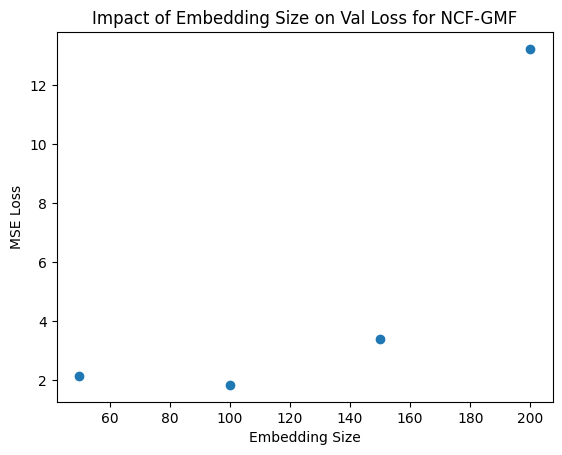

In [ ]:
# Changing embedding size
emb_sizes = [50, 100, 150, 200]
val_loss_results = []
for emb_size in emb_sizes:
    model = MF(num_users, num_items, emb_size=emb_size)
    print(f"===== Train with Embedding Size of {emb_size} ======")
    val_loss_result = train_epocs(model, epochs=10, lr=0.1, wd=0.0)
    val_loss_results.append(val_loss_result)
plt.figure()
plt.scatter(emb_sizes, val_loss_results, marker='o')  # Line plot with circle markers
plt.title("Impact of Embedding Size on Val Loss for NCF-GMF")
plt.xlabel("Embedding Size")
plt.ylabel("MSE Loss")
plt.show()

From the experiments, it can be seen that initially, increasing the embedding size led to lower MSE loss until an embedding size of 100 and afterwards embedding size increases actually led to worse model performance. This could be because with a larger embedding size, the model may be overfitting on the training data and not generalizing well to the validation/test data.


===== Train with Regularization of 0.0 ======
Epoch 0: Training loss: 12.9136  Validation loss: 4.8943
Epoch 1: Training loss: 4.8563  Validation loss: 2.5391
Epoch 2: Training loss: 2.5844  Validation loss: 3.2550
Epoch 3: Training loss: 3.1042  Validation loss: 1.0365
Epoch 4: Training loss: 0.8508  Validation loss: 2.0297
Epoch 5: Training loss: 1.8206  Validation loss: 2.8716
Epoch 6: Training loss: 2.6561  Validation loss: 2.3579
Epoch 7: Training loss: 2.1348  Validation loss: 1.3228
Epoch 8: Training loss: 1.0880  Validation loss: 1.2104
Epoch 9: Training loss: 0.9732  Validation loss: 1.8520
test loss 1.852 
===== Train with Regularization of 0.01 ======
Epoch 0: Training loss: 12.9143  Validation loss: 15.8462
Epoch 1: Training loss: 15.8719  Validation loss: 13.5858
Epoch 2: Training loss: 13.5024  Validation loss: 13.2487
Epoch 3: Training loss: 13.1636  Validation loss: 13.6575
Epoch 4: Training loss: 13.5989  Validation loss: 13.5001
Epoch 5: Training loss: 13.4266  Valida

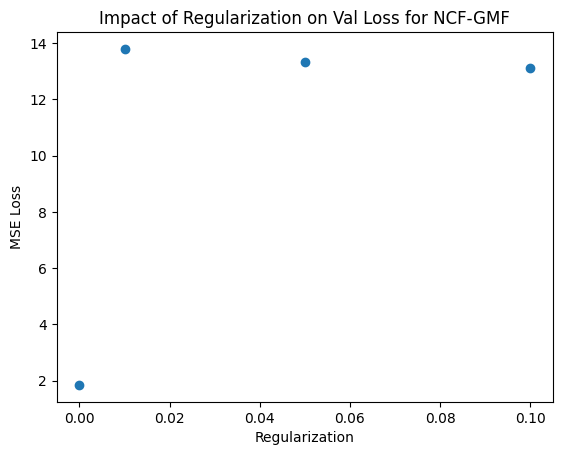

In [ ]:
# Changing Regularization
wds = [0.0, 0.01, 0.05, 0.1]
val_loss_results = []
for wd in wds:
    model = MF(num_users, num_items, emb_size=100)
    print(f"===== Train with Regularization of {wd} ======")
    val_loss_result = train_epocs(model, epochs=10, lr=0.1, wd=wd)
    val_loss_results.append(val_loss_result)
plt.figure()
plt.scatter(wds, val_loss_results, marker='o')  # Line plot with circle markers
plt.title("Impact of Regularization on Val Loss for NCF-GMF")
plt.xlabel("Regularization")
plt.ylabel("MSE Loss")
plt.show()

From the experiments, it can be seen that introducing regularization initially increases the MSE Loss for the NCF-GMF model. This is likely because when regularization is added, it restricts from fitting the data as closely as it could without regularization, which would lead to an increase in MSE loss. However, as we increase the regularization, the loss decreases slightly, showing that it has started to generalize better.

### Hyperparameter tuning experiments

In [ ]:
# Hyperparameter tuning to find the best model
wds = [0.0, 0.01, 0.05, 0.1]
emb_sizes = [50, 100, 150, 200]
results = []
i = 0
for wd in wds:
    for emb_size in emb_sizes:
        model = MF(num_users, num_items, emb_size=emb_size)
        print(f"===== Experiment {i} ======")
        print(f"wd: {wd}, emb_size: {emb_size}")
        val_loss_result = train_epocs(model, epochs=10, lr=0.1, wd=wd)
        results.append((wd, emb_size, val_loss_result))
        i += 1
print("====== Best Performing Model ======")
best_res_idx = results.index(min(results, key=lambda x: x[2]))
print(f"Best result: {results[best_res_idx][2]}")
print(f"Best hyperparameters: wd={results[best_res_idx][0]}, emb_size={results[best_res_idx][1]}")

===== Experiment 0 ======
wd: 0.0, emb_size: 50
Epoch 0: Training loss: 13.1294  Validation loss: 8.5617
Epoch 1: Training loss: 8.4959  Validation loss: 2.6067
Epoch 2: Training loss: 2.5911  Validation loss: 2.2196
Epoch 3: Training loss: 2.2080  Validation loss: 4.3094
Epoch 4: Training loss: 4.1525  Validation loss: 2.0901
Epoch 5: Training loss: 1.8957  Validation loss: 1.0125
Epoch 6: Training loss: 0.8078  Validation loss: 1.7454
Epoch 7: Training loss: 1.5392  Validation loss: 2.6095
Epoch 8: Training loss: 2.4094  Validation loss: 2.7397
Epoch 9: Training loss: 2.5459  Validation loss: 2.1493
test loss 2.149 
===== Experiment 1 ======
wd: 0.0, emb_size: 100
Epoch 0: Training loss: 12.9114  Validation loss: 4.8898
Epoch 1: Training loss: 4.8508  Validation loss: 2.5544
Epoch 2: Training loss: 2.6014  Validation loss: 3.2485
Epoch 3: Training loss: 3.0987  Validation loss: 1.0354
Epoch 4: Training loss: 0.8501  Validation loss: 2.0311
Epoch 5: Training loss: 1.8229  Validation l

From the experiments, the best performing model based on the lowest validation loss had the following hyperparameters:


*   Embedding size of 100
*   Regularization of 0.0



## NCF-MLP Model

<img src=https://miro.medium.com/v2/resize:fit:1400/format:webp/1*aP-Mx266ExwoWZPSdHtYpA.png width="600">


In [ ]:
# NCF-MLP Implementation
class my_NCF_MLP(nn.Module):
    def __init__(self, num_users, num_items, emb_size=100, hidden_size=10):
        super(my_NCF_MLP, self).__init__()

        self.user_emb = nn.Embedding(num_users, emb_size)
        self.item_emb = nn.Embedding(num_items, emb_size)
        self.user_emb.weight.data.uniform_(0, 0.05)
        self.item_emb.weight.data.uniform_(0, 0.05)

        self.fc_layers = nn.Sequential(
            nn.Linear(2*emb_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1)
        )

    def forward(self, u, v):

        u = self.user_emb(u)
        v = self.item_emb(v)

        x = torch.cat([u, v], dim=1)
        x = self.fc_layers(x).squeeze()

        return x

Train model

In [ ]:
def train_epocs(model, epochs=10, lr=0.01, wd=0.0):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    model.train()
    for epoch in range(epochs):
        # Train
        users = torch.LongTensor(df_train.userId.values) # .cuda()
        items = torch.LongTensor(df_train.movieId.values) #.cuda()
        ratings = torch.FloatTensor(df_train.rating.values) #.cuda()

        y_hat = model(users, items)
        loss = F.mse_loss(y_hat, ratings)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Val
        users_val = torch.LongTensor(df_val.userId.values) # .cuda()
        items_val = torch.LongTensor(df_val.movieId.values) #.cuda()
        ratings_val = torch.FloatTensor(df_val.rating.values) #.cuda()

        y_hat_val = model(users_val, items_val)
        loss_val = F.mse_loss(y_hat_val, ratings_val)

        print(f'Epoch {epoch}: Training loss: {loss.item():.4f}  Validation Loss: {loss_val.item():.4f}')

    # Val result
    final_val_loss_result = test_loss(model)
    return final_val_loss_result

def test_loss(model):
    model.eval()
    users = torch.LongTensor(df_val.userId.values) #.cuda()
    items = torch.LongTensor(df_val.movieId.values) #.cuda()
    ratings = torch.FloatTensor(df_val.rating.values) #.cuda()
    y_hat = model(users, items)
    loss = F.mse_loss(y_hat, ratings)
    print("test loss %.3f " % loss.item())
    return loss.item()

In [ ]:
model = my_NCF_MLP(num_users, num_items, emb_size=100, hidden_size=10)
val_loss_result = train_epocs(model, epochs=10, lr=0.1, wd=0.0)

Epoch 0: Training loss: 11.9020  Validation Loss: 6.0066
Epoch 1: Training loss: 5.9671  Validation Loss: 11.0078
Epoch 2: Training loss: 11.0880  Validation Loss: 0.9612
Epoch 3: Training loss: 0.9501  Validation Loss: 3.1275
Epoch 4: Training loss: 3.0730  Validation Loss: 4.6609
Epoch 5: Training loss: 4.5776  Validation Loss: 4.2349
Epoch 6: Training loss: 4.1560  Validation Loss: 2.5906
Epoch 7: Training loss: 2.5166  Validation Loss: 0.9083
Epoch 8: Training loss: 0.8102  Validation Loss: 1.8010
Epoch 9: Training loss: 1.6405  Validation Loss: 2.6065
test loss 2.607 


## Evaluate model parameters for NCF-MLP

### Experiment to compare the impact of changing the embedding size, hidden layers size, regularization

===== Embedding Size of 50 =====
Epoch 0: Training loss: 13.9155  Validation Loss: 7.7934
Epoch 1: Training loss: 7.7276  Validation Loss: 3.6274
Epoch 2: Training loss: 3.7202  Validation Loss: 1.3821
Epoch 3: Training loss: 1.3536  Validation Loss: 1.3240
Epoch 4: Training loss: 1.2414  Validation Loss: 2.1576
Epoch 5: Training loss: 2.0480  Validation Loss: 1.5103
Epoch 6: Training loss: 1.3756  Validation Loss: 0.9663
Epoch 7: Training loss: 0.7951  Validation Loss: 1.7110
Epoch 8: Training loss: 1.4981  Validation Loss: 1.5536
Epoch 9: Training loss: 1.3342  Validation Loss: 0.8943
test loss 0.894 
===== Embedding Size of 100 =====
Epoch 0: Training loss: 11.6072  Validation Loss: 6.0053
Epoch 1: Training loss: 5.9612  Validation Loss: 11.7334
Epoch 2: Training loss: 11.8498  Validation Loss: 0.9654
Epoch 3: Training loss: 0.9552  Validation Loss: 2.7607
Epoch 4: Training loss: 2.6981  Validation Loss: 3.9678
Epoch 5: Training loss: 3.8894  Validation Loss: 3.0306
Epoch 6: Trainin

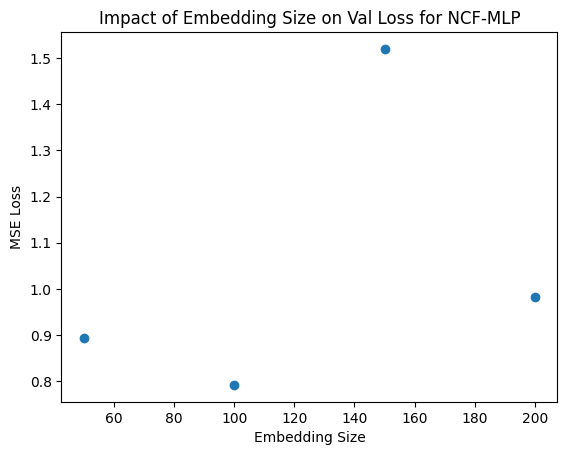

In [ ]:
# Changing embedding size
emb_sizes = [50, 100, 150, 200]
val_loss_results = []
for emb_size in emb_sizes:
    model = my_NCF_MLP(num_users, num_items, emb_size=emb_size, hidden_size=10)
    print(f"===== Embedding Size of {emb_size} =====")
    val_loss_result = train_epocs(model, epochs=10, lr=0.1, wd=0.0)
    val_loss_results.append((val_loss_result))
plt.figure()
plt.scatter(emb_sizes, val_loss_results, marker='o')  # Line plot with circle markers
plt.title("Impact of Embedding Size on Val Loss for NCF-MLP")
plt.xlabel("Embedding Size")
plt.ylabel("MSE Loss")
plt.show()

From the chart above, it can be seen that for NCF-MLP there was a general increase in the MSE loss as the embedding size increased, but it then jumped back down again for a large embedding size. This suggests that at certain intermediate sizes, there could be overfitting that's occuring which leads to increased MSE loss.

===== Hidden Layer Size of 10 =====
Epoch 0: Training loss: 12.9803  Validation Loss: 5.2135
Epoch 1: Training loss: 5.1727  Validation Loss: 27.0276
Epoch 2: Training loss: 27.1880  Validation Loss: 1.3758
Epoch 3: Training loss: 1.3642  Validation Loss: 4.0663
Epoch 4: Training loss: 3.9822  Validation Loss: 7.1192
Epoch 5: Training loss: 7.0364  Validation Loss: 6.2785
Epoch 6: Training loss: 6.3063  Validation Loss: 4.5607
Epoch 7: Training loss: 5.0140  Validation Loss: 2.8213
Epoch 8: Training loss: 3.1617  Validation Loss: 1.1998
Epoch 9: Training loss: 1.2368  Validation Loss: 1.0647
test loss 1.065 
===== Hidden Layer Size of 20 =====
Epoch 0: Training loss: 13.5105  Validation Loss: 8.8966
Epoch 1: Training loss: 8.8295  Validation Loss: 12.6079
Epoch 2: Training loss: 12.7464  Validation Loss: 1.0836
Epoch 3: Training loss: 1.0783  Validation Loss: 4.9246
Epoch 4: Training loss: 4.8616  Validation Loss: 5.9688
Epoch 5: Training loss: 5.8905  Validation Loss: 4.0147
Epoch 6: 

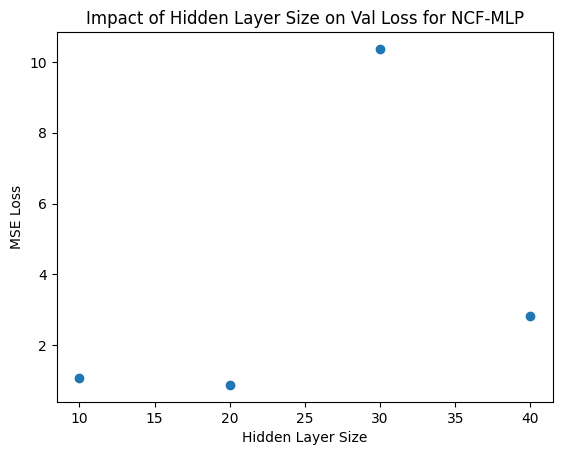

In [ ]:
# Changing hidden layer size
hidden_layers = [10, 20, 30, 40]
val_loss_results = []
for hidden_size in hidden_layers:
    model = my_NCF_MLP(num_users, num_items, emb_size=100, hidden_size=hidden_size)
    print(f"===== Hidden Layer Size of {hidden_size} =====")
    val_loss_result = train_epocs(model, epochs=10, lr=0.1, wd=0.0)
    val_loss_results.append((val_loss_result))
plt.figure()
plt.scatter(hidden_layers, val_loss_results, marker='o')  # Line plot with circle markers
plt.title("Impact of Hidden Layer Size on Val Loss for NCF-MLP")
plt.xlabel("Hidden Layer Size")
plt.ylabel("MSE Loss")
plt.show()

Similar to the embedding size, there was a general increase in the MSE loss as the hidden layer size increased, but it then jumped back down again for a large hidden layer size. This suggests that at certain intermediate sizes, there could be overfitting that's occuring which leads to increased MSE loss.


===== Regularization of 0.0 =====
Epoch 0: Training loss: 13.7428  Validation Loss: 9.0069
Epoch 1: Training loss: 8.9385  Validation Loss: 4.0488
Epoch 2: Training loss: 4.1341  Validation Loss: 1.3067
Epoch 3: Training loss: 1.2811  Validation Loss: 1.4234
Epoch 4: Training loss: 1.3554  Validation Loss: 2.0963
Epoch 5: Training loss: 2.0034  Validation Loss: 1.2874
Epoch 6: Training loss: 1.1626  Validation Loss: 1.2598
Epoch 7: Training loss: 1.0760  Validation Loss: 1.6982
Epoch 8: Training loss: 1.4835  Validation Loss: 0.9265
Epoch 9: Training loss: 0.7399  Validation Loss: 1.1011
test loss 1.101 
===== Regularization of 0.01 =====
Epoch 0: Training loss: 14.6178  Validation Loss: 14.6890
Epoch 1: Training loss: 14.5831  Validation Loss: 10.4315
Epoch 2: Training loss: 10.2606  Validation Loss: 9.5845
Epoch 3: Training loss: 10.1883  Validation Loss: 1.8608
Epoch 4: Training loss: 1.9193  Validation Loss: 2.6200
Epoch 5: Training loss: 2.5832  Validation Loss: 3.9736
Epoch 6: Tr

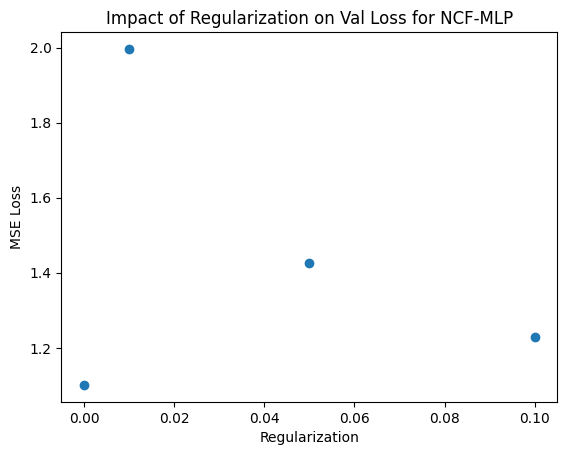

In [ ]:
# Changing regularization
wds = [0.0, 0.01, 0.05, 0.1]
val_loss_results = []
for wd in wds:
    model = my_NCF_MLP(num_users, num_items, emb_size=100, hidden_size=10)
    print(f"===== Regularization of {wd} =====")
    val_loss_result = train_epocs(model, epochs=10, lr=0.1, wd=wd)
    val_loss_results.append((val_loss_result))
plt.figure()
plt.scatter(wds, val_loss_results, marker='o')  # Line plot with circle markers
plt.title("Impact of Regularization on Val Loss for NCF-MLP")
plt.xlabel("Regularization")
plt.ylabel("MSE Loss")
plt.show()

From the experiments, it can be seen that introducing regularization initially increases the MSE Loss but as we increase the regularization, the loss decreases. This is likely because when regularization is added, it restricts from fitting the data as closely as it could without regularization, which would lead to an increase in MSE loss but with higher regularization, it allows the model to generalize better which would lead to a decrease in the MSE loss.

### Hyperparameter tuning experiments

In [ ]:
results = []
i = 0
for wd in [0.0, 0.01, 0.05, 0.1]:
    for emb_size in [50, 100, 150, 200]:
        for hidden_size in [10, 20, 30, 40]:
            print(f"===== Experiment {i} =====")
            print(f"wd: {wd}, emb_size: {emb_size}, hidden_size: {hidden_size}")
            model = my_NCF_MLP(num_users, num_items, emb_size=emb_size, hidden_size=hidden_size)
            test_loss_result = train_epocs(model, epochs=10, lr=0.1, wd=wd)
            results.append((wd, emb_size, hidden_size, test_loss_result))
            i += 1
print("====== Best Performing Model ======")
best_res_idx = results.index(min(results, key=lambda x: x[3]))
print(f"Best result: {results[best_res_idx][3]}")
print(f"Best hyperparameters: wd={results[best_res_idx][0]}, emb_size={results[best_res_idx][1]}, hidden_size={results[best_res_idx][2]}")

===== Experiment 0 =====
wd: 0.0, emb_size: 50, hidden_size: 10
Epoch 0: Training loss: 11.7755  Validation Loss: 8.4260
Epoch 1: Training loss: 8.3618  Validation Loss: 1.6230
Epoch 2: Training loss: 1.6295  Validation Loss: 8.8421
Epoch 3: Training loss: 8.8802  Validation Loss: 1.4802
Epoch 4: Training loss: 1.4659  Validation Loss: 2.2385
Epoch 5: Training loss: 2.1807  Validation Loss: 4.1029
Epoch 6: Training loss: 4.0187  Validation Loss: 3.1165
Epoch 7: Training loss: 3.0448  Validation Loss: 1.4820
Epoch 8: Training loss: 1.4513  Validation Loss: 1.0204
Epoch 9: Training loss: 1.0360  Validation Loss: 1.5209
test loss 1.521 
===== Experiment 1 =====
wd: 0.0, emb_size: 50, hidden_size: 20
Epoch 0: Training loss: 12.7438  Validation Loss: 7.3986
Epoch 1: Training loss: 7.3412  Validation Loss: 10.6434
Epoch 2: Training loss: 10.7663  Validation Loss: 1.0404
Epoch 3: Training loss: 1.0315  Validation Loss: 2.5003
Epoch 4: Training loss: 2.4457  Validation Loss: 4.4668
Epoch 5: Tr

From the experiments, the best performing model based on the lowest validation loss had the following hyperparameters:


*   Embedding size of 100
*   Regularization of 0.01
*   Hidden layer size of 10


## Comparison of the best NCF-GMF and NCF-MLP models

The below table summarizes the results for the best NCF-GMF and NCF-MLP models. Overall, the NCF-MLP model achieved a lower validation loss than the NCF-GMF model.


| Model       | Hyperparameters    | Val Loss Result   |
|-------------|--------------------|-------------------|
| NCF-GMF     | wd=0.0, emb_size=100 | 1.8510          |
| NCF-MLP     | wd=0.01, emb_size=100, hidden_size=10 | 0.9140 |          

## Change to Binary Ratings (1 or 0)

In [ ]:
def binarize_data(df):
    """ Encodes rating data to be 1 or 0."""
    df = df.copy()
    df["rating"] = df["rating"].apply(lambda x: 1.0 if x >= 3 else 0.0)
    return df

In [ ]:
df_train_bin = binarize_data(df_train)
df_val_bin = binarize_data(df_val)

In [ ]:
df_train_bin.head()

,userId,movieId,rating,timestamp
0,0,0,1.0,964982703
1,0,1,1.0,964981247
2,0,2,1.0,964982224
3,0,3,1.0,964983815
6,0,4,1.0,964980868


In [ ]:
# NCF-GMF Model - switch train loop to use binarized data
def train_epocs(model, epochs=10, lr=0.01, wd=0.0):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    model.train()
    for i in range(epochs):
        # Train
        users = torch.LongTensor(df_train_bin.userId.values) # .cuda()
        items = torch.LongTensor(df_train_bin.movieId.values) #.cuda()
        ratings = torch.FloatTensor(df_train_bin.rating.values) #.cuda()

        y_hat = model(users, items)
        loss = F.mse_loss(y_hat, ratings)
        optimizer.zero_grad()

        loss.backward()
        optimizer.step()

        # Val
        users_val = torch.LongTensor(df_val_bin.userId.values) # .cuda()
        items_val = torch.LongTensor(df_val_bin.movieId.values) #.cuda()
        ratings_val = torch.FloatTensor(df_val_bin.rating.values) #.cuda()

        y_hat_val = model(users_val, items_val)
        loss_val = F.mse_loss(y_hat_val, ratings_val)

        # Display loss
        print(f"Epoch {i}: Training loss: {loss.item():.4f}  Validation loss: {loss_val.item():.4f}")

    final_val_loss_value = test_loss(model)
    return final_val_loss_value

def test_loss(model):
    model.eval()
    users = torch.LongTensor(df_val_bin.userId.values) #.cuda()
    items = torch.LongTensor(df_val_bin.movieId.values) #.cuda()
    ratings = torch.FloatTensor(df_val_bin.rating.values) #.cuda()
    y_hat = model(users, items)
    loss = F.mse_loss(y_hat, ratings)
    print("test loss %.3f " % loss.item())
    return loss.item()

# Best NCF-GMF Model
model = MF(num_users, num_items, emb_size=100)
val_loss_result = train_epocs(model, epochs=10, lr=0.1, wd=0.0)

Epoch 0: Training loss: 0.7124  Validation loss: 0.6897
Epoch 1: Training loss: 0.6684  Validation loss: 0.2764
Epoch 2: Training loss: 0.2617  Validation loss: 0.5413
Epoch 3: Training loss: 0.5215  Validation loss: 0.5745
Epoch 4: Training loss: 0.5458  Validation loss: 0.4907
Epoch 5: Training loss: 0.4491  Validation loss: 0.3998
Epoch 6: Training loss: 0.3496  Validation loss: 0.3715
Epoch 7: Training loss: 0.3202  Validation loss: 0.2689
Epoch 8: Training loss: 0.2262  Validation loss: 0.2001
Epoch 9: Training loss: 0.1691  Validation loss: 0.2296
test loss 0.230 


In [ ]:
# NCF-MLP Model - switch train loop to use binarized data
def train_epocs(model, epochs=10, lr=0.01, wd=0.0):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=wd)
    model.train()
    for epoch in range(epochs):
        # Train
        users = torch.LongTensor(df_train_bin.userId.values) # .cuda()
        items = torch.LongTensor(df_train_bin.movieId.values) #.cuda()
        ratings = torch.FloatTensor(df_train_bin.rating.values) #.cuda()

        y_hat = model(users, items)
        loss = F.mse_loss(y_hat, ratings)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Val
        users_val = torch.LongTensor(df_val_bin.userId.values) # .cuda()
        items_val = torch.LongTensor(df_val_bin.movieId.values) #.cuda()
        ratings_val = torch.FloatTensor(df_val_bin.rating.values) #.cuda()

        y_hat_val = model(users_val, items_val)
        loss_val = F.mse_loss(y_hat_val, ratings_val)

        print(f'Epoch {epoch}: Training loss: {loss.item():.4f}  Validation Loss: {loss_val.item():.4f}')

    # Val result
    final_val_loss_result = test_loss(model)
    return final_val_loss_result

def test_loss(model):
    model.eval()
    users = torch.LongTensor(df_val_bin.userId.values) #.cuda()
    items = torch.LongTensor(df_val_bin.movieId.values) #.cuda()
    ratings = torch.FloatTensor(df_val_bin.rating.values) #.cuda()
    y_hat = model(users, items)
    loss = F.mse_loss(y_hat, ratings)
    print("test loss %.3f " % loss.item())
    return loss.item()

# Best NCF-MLP Model
model = my_NCF_MLP(num_users, num_items, emb_size=100, hidden_size=10)
val_loss_result = train_epocs(model, epochs=10, lr=0.1, wd=0.01)

Epoch 0: Training loss: 0.6702  Validation Loss: 0.7594
Epoch 1: Training loss: 0.7479  Validation Loss: 0.2823
Epoch 2: Training loss: 0.2819  Validation Loss: 0.3694
Epoch 3: Training loss: 0.3830  Validation Loss: 0.2585
Epoch 4: Training loss: 0.2624  Validation Loss: 0.1839
Epoch 5: Training loss: 0.1908  Validation Loss: 0.2264
Epoch 6: Training loss: 0.2384  Validation Loss: 0.2183
Epoch 7: Training loss: 0.2309  Validation Loss: 0.1679
Epoch 8: Training loss: 0.1749  Validation Loss: 0.1598
Epoch 9: Training loss: 0.1617  Validation Loss: 0.1737
test loss 0.174 


Using the best NCF-GMF and NCF-MLP models, the following table summarizes the results that were obtained with using binary ratings. Consistent with previous findings, the NCF-MLP model exhibited a lower validation loss than the NCF-GMF model. Notably, the validation loss for both models was lower compared to their performance with non-binarized ratings. This result aligns with expectations, as predicting binary ratings is generally simpler than predicting a broader range of ratings (1-5). To change the model implementation to better conform to the dataset, we can incorporate a sigmoid activation function at the end to ensure the output values are between 0 and 1 to align with the binary ratings.

| Model       | Hyperparameters    | Val Loss Result   |
|-------------|--------------------|-------------------|
| NCF-GMF     | wd=0.0, emb_size=100 | 0.230          |
| NCF-MLP     | wd=0.01, emb_size=100, hidden_size=10 | 0.174  |    